# 线性回归

·假设1∶影响房价的关键因素是卧室个数，卫生间个数，和居住面积，记为X1,X2,X3
·假设2:成交价是关键因素的加权和
$$
y=w_{1} x_{1}+w_{2} x_{2}+\ldots+w_{n} x_{n}+b
$$

线性模型可以看成单层神经网络

## 1. 线性回归的从零开始实现
将会从零开始实现整个方法，包括数据流水线，模型，损失函数和小批量随机梯度下降优化器

In [5]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数，w =[2,-3.4]^T.b =4.2 和噪声项 espilon 生成数据集及其标签:
$$
\mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon
$$

In [30]:
def synthetic_data(w,b,num_examples):
	"""构造 y = Xw + b + 噪声"""
	X = torch.normal(0, 1, (num_examples, len(w)))
	y = torch.matmul(X, w) + b
	y += torch.normal(0, 0.01, y.shape)
	return X, y.reshape((-1, 1))
true_w = torch.Tensor([2, -3.4])
true_b = 2.1
feathers, labels = synthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels 中的每一行都包含一维标签值(—个标量)

In [8]:
print('feathers:', feathers[0], '\nlabels:', labels[0])


feathers: tensor([-0.5836,  1.8973]) 
labels: tensor([-5.5180])


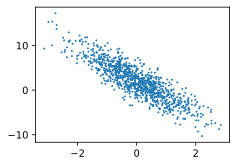

In [10]:
d2l.set_figsize()
d2l.plt.scatter(feathers[:,1].detach().numpy(),
				labels.detach().numpy(), 1)

定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签尚量作为输入，生成大小为batch_size的小批量

In [11]:
def data_iter(batch_size, feathers, labels):
	num_examples = len(feathers)
	indices = list(range(num_examples))
	random.shuffle(indices)
	for i in range(0, num_examples, batch_size):
		batch_indices = torch.tensor(indices[i:min(i+batch_size, 
						num_examples)])
		yield feathers[batch_indices], labels[batch_indices]

In [12]:
batch_size = 10

for X, y in data_iter(batch_size, feathers, labels):
	print(X, '\n', y)
	break

tensor([[-0.3160,  0.4972],
        [-0.4645,  0.2828],
        [ 0.9324,  0.1875],
        [-0.0150,  0.0769],
        [ 0.7398, -0.8080],
        [-0.5643, -0.1856],
        [ 0.4508, -0.0045],
        [-0.3770, -0.7204],
        [-0.7807, -1.0691],
        [-1.3228, -0.3994]]) 
 tensor([[-0.2439],
        [ 0.2141],
        [ 3.3399],
        [ 1.8114],
        [ 6.3150],
        [ 1.6162],
        [ 3.0289],
        [ 3.7875],
        [ 4.1463],
        [ 0.8050]])


In [27]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size = (2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [14]:
# 定义模型
def linreg(X, w, b):
	return torch.matmul(X, w) + b

In [15]:
# 定义损失函数
def square_loss(y_hat, y):
	"""均方误差"""
	return (y_hat - y.reshape(y_hat.shape))**2 / 2 

In [17]:
#定义优化算法
def sgd(params, lr, batch_size):
	"""小批量随机梯度下降"""
	with torch.no_grad():
		for param in params:
			param -= lr * param.grad / batch_size
			param.grad.zero_()

In [29]:
# 训练过程
lr = 0.03
num_epoches = 10
net = linreg
loss = square_loss

for epoch in range(num_epoches):
	for X, y in data_iter(batch_size, feathers, labels):
		l = loss(net(X, w, b), y)
		l.sum().backward()
		sgd([w, b], lr, batch_size)
	with torch.no_grad():
		train_1 = loss(net(feathers, w, b), labels)
		print(f'epoch {epoch + 1}, loss {float(train_1.mean()): f}')

epoch 1, loss  0.000054
epoch 2, loss  0.000054
epoch 3, loss  0.000053
epoch 4, loss  0.000053
epoch 5, loss  0.000053
epoch 6, loss  0.000054
epoch 7, loss  0.000053
epoch 8, loss  0.000054
epoch 9, loss  0.000053
epoch 10, loss  0.000053


In [24]:
print(f'w 的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b 的估计误差：{true_b - b}')

w 的估计误差：tensor([-0.0009, -0.0007], grad_fn=<SubBackward0>)
b 的估计误差：tensor([0.0003], grad_fn=<RsubBackward1>)


## 2. 线性回归的简洁实现

通过深度学习框架来简洁地实现 线性回归模型 生成数据集

In [33]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
feathers, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [34]:
def load_array(data_arrays, batch_size, is_train=True):
	dataset = data.TensorDataset(*data_arrays)
	return data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((feathers, labels), batch_size)
next(iter(data_iter))


[tensor([[-1.9293,  0.8308],
         [-0.2169,  1.5577],
         [-2.6345,  0.8681],
         [ 0.9228, -1.1915],
         [ 0.1457,  1.4331],
         [-0.5349,  2.7405],
         [-1.6329, -0.0092],
         [ 0.0032, -0.5567],
         [ 0.4954,  0.4156],
         [-2.0258,  0.2186]]),
 tensor([[-2.4869],
         [-1.5156],
         [-4.0328],
         [10.0882],
         [-0.3808],
         [-6.1797],
         [ 0.9691],
         [ 6.1061],
         [ 3.7826],
         [-0.5811]])]

In [35]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [43]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [40]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), 0.03)

In [44]:
num_epoches = 3
for epoch in range(num_epoches):
	for X, y in data_iter:
		l = loss(net(X), y)
		trainer.zero_grad()  # 清空梯度
		l.backward()
		trainer.step()
	l = loss(net(feathers), labels)
	print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000169
epoch 2, loss 0.000092
epoch 3, loss 0.000092
